In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scp
import numpy as np
import random as rd
import seaborn as sns
import scipy.special as sc
import math
import subprocess
import concurrent.futures
import time
from Tools import *

#### The simalator used in this nootebook

In [2]:
def simulator(mu, n_initial, n_final, death_rate, fitness, param, n_sample):
    parameters = f"{n_initial},{n_final} {death_rate} {float(mu)} {fitness} {param} {n_sample} 1"
    command = ['./atreyu_forward_simulator'] + parameters.split()
    
    process = subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    stdout, _ = process.communicate()
    output_lines = stdout.strip().split('\n')
    int_list = [int(line.split()[0]) for line in output_lines]
    return int_list

###### Fixed parameters

In [3]:
n_initial = 10
n_final = 1e7
param = 1
seed = 1
dt = 0.3
n_sample = 300

### Rejection Algorithme ABC for mu and fitness

The simulation takes a lot of time and seems to run indefinitely, especially when the mutation rate (mu) is quite small, and the fitness is large or vice versa. That's why we reduce the fitness and mu intervals. 

The simulator's runtime is dependent on the number of simulations conducted. Therefore, we should find a method to reduce the simulation size without compromising the comparison test using the Kolmogorov-Smirnov test.
With small sample sizes, the K-S test may have low power and may not detect differences between distributions even when they exist.

We will investigate the impact of simulation size on the Kolmogorov-Smirnov test and determine the smallest simulation size that aligns well with our observed data (300 samples).  

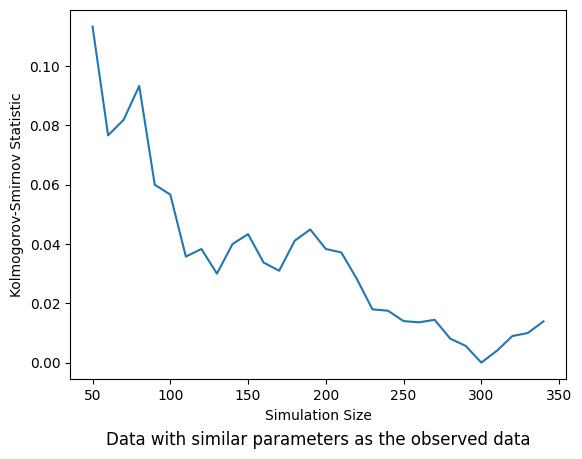

Simulate data with similar parameters as the observed data, but with varying sizes:
Simulating data with slight variance in the parameters compared to the observed data and with varying sizes, we aim to investigate whether we can detect differences between the observed data and small size simulations


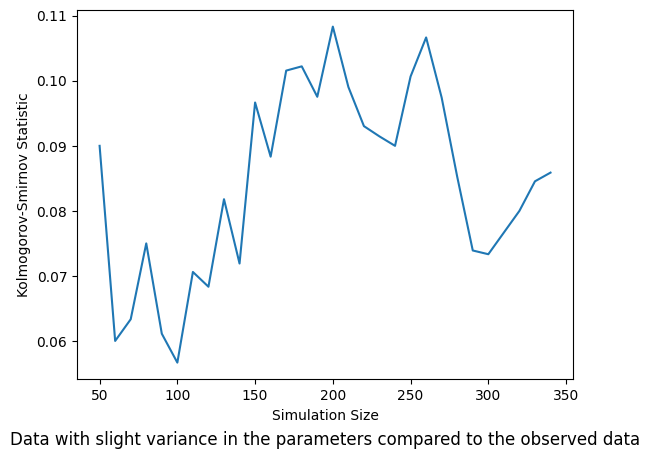

In [4]:
dataTestsize = simulator(5e-7,n_initial,n_final,0.3,0.96,param,n_sample)
size = [i for i in range(50,350,10)]
ks_size = []
for s in size:
    d1 = simulator(5e-7,n_initial,n_final,0.3,0.96,param,s)
    ks, p =  scp.ks_2samp(d1,dataTestsize)
    ks_size.append(ks)
plt.plot(size, ks_size)
# Add labels and title
plt.xlabel('Simulation Size')
plt.ylabel('Kolmogorov-Smirnov Statistic')
plt.title('Data with similar parameters as the observed data',loc="center",y=-0.2)
plt.show()
print('Simulate data with similar parameters as the observed data, but with varying sizes:')
ks_size1 = []
for s in size:
    # changing the fitness and mutation rate slightly
    d1 = simulator(5.2e-7,n_initial,n_final,0.3,1,param,s)
    ks, p =  scp.ks_2samp(d1,dataTestsize)
    ks_size1.append(ks)

print('Simulating data with slight variance in the parameters compared to the observed data and with varying sizes, we aim to investigate whether we can detect differences between the observed data and small size simulations')
plt.plot(size, ks_size1)
# Add labels and title
plt.xlabel('Simulation Size')
plt.ylabel('Kolmogorov-Smirnov Statistic')
plt.title('Data with slight variance in the parameters compared to the observed data',loc="center",y=-0.2)

# Display the plot
plt.show()

We observe that the simulation with 300 samples yields a KS test result close to other simulations with a smaller number of samples, particularly when the size is greater than 200. Thus, we conclude that the KS test is not highly sensitive to the size of the compared data, especially when considering a size larger than 200. To generalize this study, we will reduce the sample size to 60% of the original size in case we need to speed up the computation.



##### Rejection Algorithme ABC for mu and fitness

In [6]:
true_mu = 8e-8
true_f = 1
observed_data = simulator(true_mu,n_initial,n_final,dt,true_f,param,n_sample)

In [7]:
def plot_hit_map(df_values): 
    best_couple = df_values[df_values["ks"] == min(df_values["ks"])]
    best_f = np.mean(best_couple["f"])
    best_mu = np.mean(best_couple["mu"])
    # Create a scatter plot of mu vs. f, color-coded by the KS p-value
    plt.scatter(df_values["mu"], df_values["f"], c= df_values["ks"])
    plt.colorbar(label='KS p-value')
    plt.title("Different couple and distance with given distribution")
    # Plot a single point for the best couple of parameters
    plt.scatter(best_mu, best_f, marker='x', color='r', s=80)
    plt.scatter(true_mu, true_f, marker='x', color='g', s=80)
    # Plot a single point for the true values
    plt.show()

def rejection_algorithm(N,n_initial,n_final,dt, param,observed_data,ks_seuil):
    values = []
    n_sample_ech = 0.6*len(observed_data)
    for i in range(N) :
        mu = scp.loguniform.rvs(1e-11, 1e-6)
        f = scp.loguniform.rvs(0.1, 2)
        generated_df = simulator(mu,n_initial,n_final,dt,f, param,n_sample_ech)
        ks, p = scp.ks_2samp(generated_df,observed_data,mode = "asymp")
        values.append({"mu": mu, "f": f, "ks": ks})
    couples_ks = pd.DataFrame(values)
    posterior = couples_ks[couples_ks["ks"] <= ks_seuil]
    best_couple = couples_ks[couples_ks["ks"] == min(couples_ks["ks"])]
    best_f = np.mean(best_couple["f"])
    best_mu = np.mean(best_couple["mu"])
    return best_mu, best_f,posterior

In [8]:
best_mu, best_f,posterior = rejection_algorithm(N=4000, n_initial=n_initial, n_final=n_final, dt=dt, param=param,observed_data= observed_data,ks_seuil = 0.1)

In [9]:
print("True couple (f,mu) is",true_f,true_mu)
print("Best couple (f,mu) is ", best_f,best_mu)
print("Relatif error for (f,mu) is " ,abs(best_f- true_f) / true_f,abs(best_mu - true_mu)/ true_mu)

True couple (f,mu) is 1 8e-08
Best couple (f,mu) is  0.874207531859558 7.570078613194039e-08
Relatif error for (f,mu) is  0.12579246814044198 0.05374017335074512


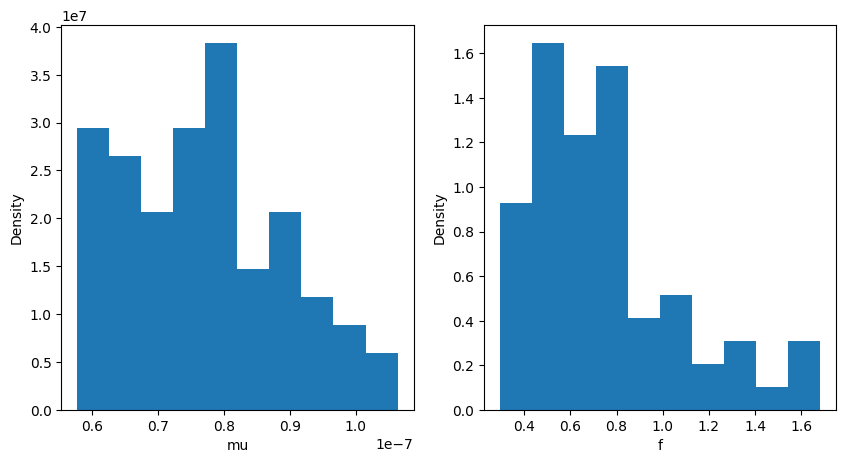

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram of posterior distribution of mu
axs[0].hist(posterior["mu"],density=True)
axs[0].set_xlabel("mu")
axs[0].set_ylabel("Density")

# Plot histogram of posterior distribution of f
axs[1].hist(posterior["f"],density=True)
axs[1].set_xlabel("f")
axs[1].set_ylabel("Density")

plt.show()

In [11]:
mu_samples = posterior["mu"]
f_samples = posterior["f"]

mu_ci = np.percentile(mu_samples, [2.5, 97.5])
f_ci = np.percentile(f_samples, [2.5, 97.5])

print("95% CI for mu:", mu_ci)
print("95% CI for f:", f_ci)

95% CI for mu: [5.80477445e-08 9.93448174e-08]
95% CI for f: [0.3085144 1.6314449]


In [12]:
from math import sqrt

def grid_sampling_algo(N, n_initial, n_final, dt, param, observed_data,ks_seuil):
    echant_inter = int(sqrt(N))
    step_f = (2 - 0.1) / echant_inter
    step_mu = (1e-6 - 1e-11) / echant_inter
    values = []
    n_sample_ech = 0.6*len(observed_data)
    for f in range(int(echant_inter)):
        current_f = 0.1 + f * step_f
        for mu in range(int(echant_inter)):
            current_mu = 1e-11 + mu * step_mu          
            generated_df = simulator(current_mu,n_initial,n_final,dt,current_f, param,n_sample_ech)
            ks, p = scp.ks_2samp(generated_df,observed_data,mode = "asymp")
            values.append({"mu": current_mu, "f": current_f, "ks": ks})
    couples_ks = pd.DataFrame(values)
    plot_hit_map(couples_ks)
    posterior = couples_ks[couples_ks["ks"] <= ks_seuil]
    best_couple = couples_ks[couples_ks["ks"] == min(couples_ks["ks"])]
    best_f = np.mean(best_couple["f"])
    best_mu = np.mean(best_couple["mu"])
    return best_mu, best_f,posterior

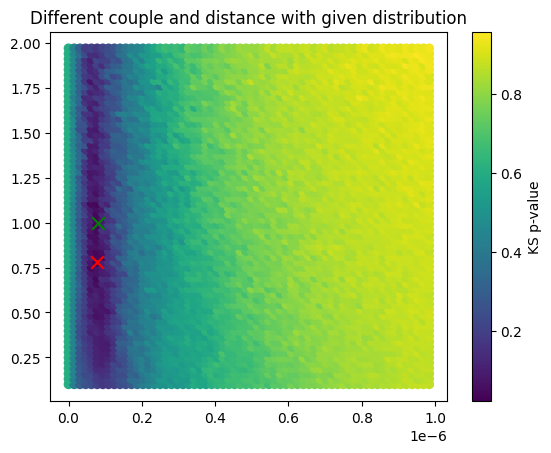

In [13]:
best_mu2, best_f2 ,posterior2 = grid_sampling_algo(N=4096, n_initial=n_initial, n_final=n_final, dt=dt, param=param, observed_data= observed_data,ks_seuil=0.1)

In [14]:
print("True couple (f,mu) is",true_f,true_mu)
print("Best couple (f,mu) is ", best_f2,best_mu2)
print("Relatif error for (f,mu) is " ,abs(best_f2- true_f) / true_f,abs(best_mu2 - true_mu)/ true_mu)

True couple (f,mu) is 1 8e-08
Best couple (f,mu) is  0.7828124999999999 7.813421874999999e-08
Relatif error for (f,mu) is  0.2171875000000001 0.02332226562500015


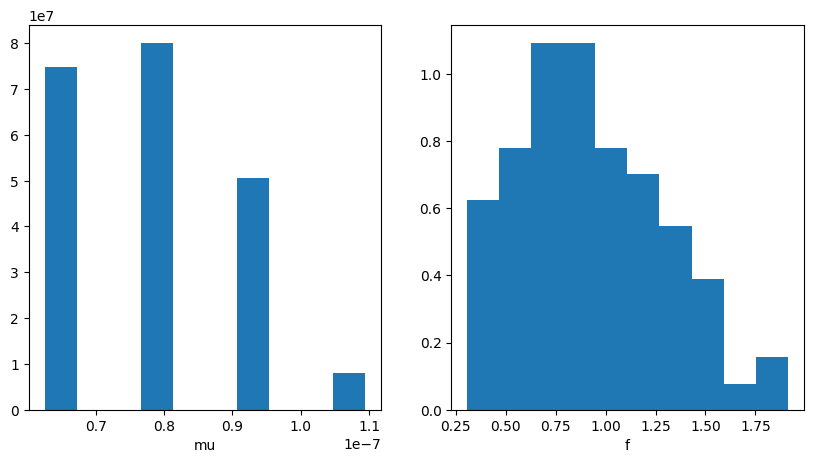

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram of posterior distribution of mu
axs[0].hist(posterior2["mu"],density=True)
axs[0].set_xlabel("mu")


# Plot histogram of posterior distribution of f
axs[1].hist(posterior2["f"],density=True)
axs[1].set_xlabel("f")

plt.show()

In [16]:
mu_samples = posterior2["mu"]
f_samples = posterior2["f"]

mu_ci = np.percentile(mu_samples, [2.5, 97.5])
f_ci = np.percentile(f_samples, [2.5, 97.5])

print("95% CI for mu:", mu_ci)
print("95% CI for f:", f_ci)

95% CI for mu: [6.25093750e-08 1.09383906e-07]
95% CI for f: [0.33675781 1.64746094]


## the MCMC ABC algorithm on the couple (mu,deathRate):

We choose the exponential transition kernel because it enables us to explore the entire interval around the previously parameter value, so we set the mean of the distribution to that previous value. Since we lack information about the prior, a log-uniform distribution would be a more suitable choice.

The first idea we will try is to accept values based on the similarity between the previous value and the proposed value with respect to the experimental data. The probability to accept an element is:
$ \\ \alpha(x, x') = \min \left(1, \frac{p(x')q(x'|x)ksscurrent}{p(x)q(x|x')kssproposed} \right)$

The following code implements MCMC using the aforementioned idea:


In [17]:
"""Transition kernel is separately defined
    in a function so it is easy to redefine"""
def transition_kernel_rvs_mu(mu_1):
    mu = np.random.exponential(mu_1)
    while (mu < 1e-11) or (mu > 1e-5) :
        mu = np.random.exponential(mu_1)
    return mu


def transition_kernel_rvs_f(f_1):
    f = np.random.exponential(f_1)
    while  (f > 2) or (f < 0.1):
        f = np.random.exponential(f_1)
    return f
    


def transition_kernel_pdf(mu_1, mu_2, f_1, f_2):
    gauss_pdf = scp.expon.pdf(mu_1, loc=0, scale=mu_2)
    expon_pdf = scp.expon.pdf(f_1, loc=0, scale=f_2)
    return gauss_pdf * expon_pdf

"""Prior is separately defined in a function so it
    is easier to redefine"""
def Prior(mu,f,prior_type_mu,prior_type_f):
    if prior_type_mu == "log_uniform" :
        a_mu = scp.loguniform.pdf(mu,1e-11, 1e-5)
    elif prior_type_mu == "uniform" :
        a_mu = scp.uniform.pdf(mu,1e-11,1e-5)
    elif prior_type_mu == "gamma":
        a_mu = scp.gamma.pdf(mu, alpha, scale=1/beta)
    elif prior_type_mu == "exponential":
        a_mu = scp.expon.pdf(np.median(observed_data)/n_final)
    else:
        raise ValueError("Invalid prior_type_mu, must be one of 'log_uniform', 'uniform', 'gamma'")
    
    if prior_type_f == "log_uniform" :
        a_f = scp.loguniform.pdf(f,0.1, 2)
    elif prior_type_f == "uniform" :
        a_f = scp.uniform.pdf(f,0.1,2)
    elif prior_type_f == "gamma":
        a_f = scp.gamma.pdf(f, alpha, scale=1/beta)

    else:
        raise ValueError("Invalid prior_type_f, must be one of 'log_uniform', 'uniform', 'gamma'")
    
    return a_mu * a_f    


In [21]:
def metropolis_hastingsVariant(p, mu_0,prior_type_mu,prior_type_f, observed_data, n_initial, n_final, f_0, dt, param, n_sample):
    current_val = [mu_0,f_0]
    mu_values = [current_val[0]]
    f_values = [current_val[1]]
    proposed_values = [current_val] # <- Used to compare accepted values to all values
    
    for i in range(p):
        # We generate a candidate mu from which we generate a distribution y
        proposed_val = (transition_kernel_rvs_mu(current_val[0]),transition_kernel_rvs_f(current_val[1]))
        proposed_values.append(proposed_val)
        
        dataproposed = simulator(proposed_val[0], n_initial, n_final, dt, proposed_val[1], param, n_sample)
        datacurrent = simulator(current_val[0], n_initial, n_final, dt, current_val[1], param, n_sample)
        
        ksProposed, p_values = scp.ks_2samp(observed_data, dataproposed)
        ksCurrent, p_values = scp.ks_2samp(observed_data, datacurrent)
     
        prior2 = Prior(current_val[0],current_val[1],prior_type_mu,prior_type_f)
        prior1 = Prior(proposed_val[0],proposed_val[1],prior_type_mu,prior_type_f)
        trk1 =  transition_kernel_pdf(current_val[0],proposed_val[0],current_val[1],proposed_val[1])
        trk2 = transition_kernel_pdf(proposed_val[0],current_val[0],proposed_val[1],current_val[1])
        if ksProposed == 0:
            alpha =1
        elif ksCurrent/ksProposed>=0.95:
            # in case prior or ksproposed a equal to zero we accept the couple (current_mu , current_dr)
            if trk2 ==0 or prior2 == 0:
                continue
            
            else:
                r1 = prior1 / prior2
                #r2 = (trk1)/ (trk2)
                #we can also use expential
                r2 = (trk1*ksCurrent)/ (trk2*ksProposed)
                alpha = min(1,r1*r2)

            # Accept or reject proposal
            u = np.random.uniform(0, 1)
            if u <= alpha:
                current_val[0] = proposed_val[0]
                current_val[1] = proposed_val[1]
        mu_values.append(current_val[0])
        f_values.append(current_val[1])

    return mu_values,f_values ,proposed_values

In [23]:
mu_0 = (1e-11+ 1e-5)/2 #la valeur centrale de l'intervalle de mu
f_0 = (0.1 + 2)/2 #la valeur centrale de l'intervalle de f
mu = 5e-8
f = 0.78
observed_data = simulator(mu,n_initial,n_final,0.3,f,param,1000)
mu_values,f_values,proposed_values = metropolis_hastingsVariant(10000, mu_0,"log_uniform","log_uniform", observed_data, n_initial, n_final, f_0,0.3, param, 200)

KstestResult(statistic=0.01, pvalue=0.999999999805234)


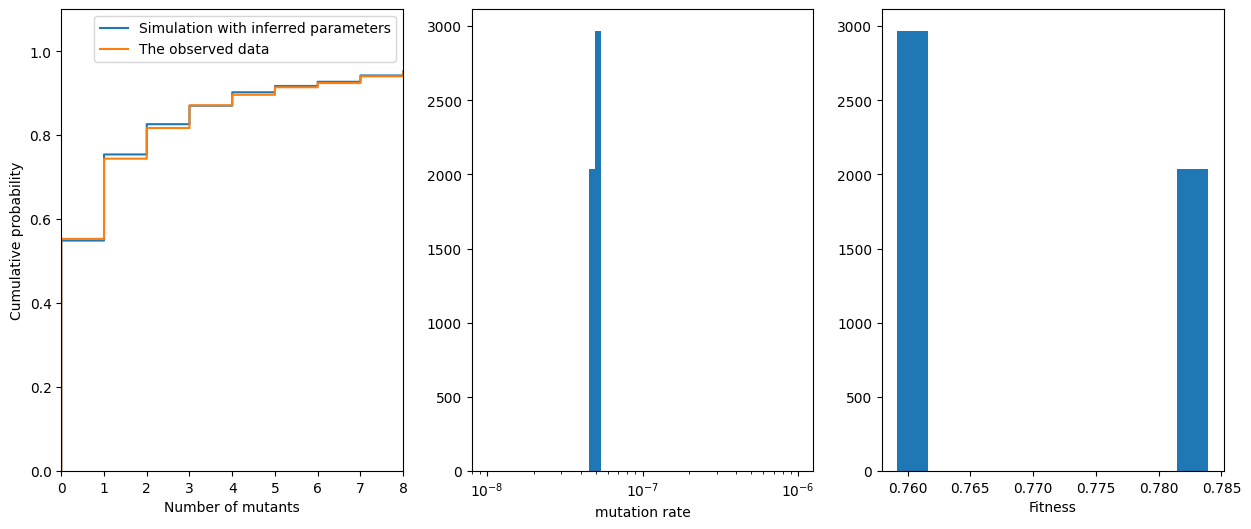

In [24]:
posterior = simulator(np.mean(mu_values[-5000:]),n_initial,n_final,0.3,np.mean(f_values[-5000:]),param,1000)
maxdifference = scp.ks_2samp(posterior,observed_data)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15 ,6))
print(maxdifference)
plot_cdf(posterior,observed_data, axes[0])
bins = np.logspace(start=-8, stop=-6, num=50)
axes[1].hist(mu_values[-5000:],bins=bins)
axes[1].set_xlabel("mutation rate")
axes[1].set_xscale('log')
axes[2].hist(f_values[-5000:])
axes[2].set_xlabel("Fitness")
plt.savefig("figrapport")

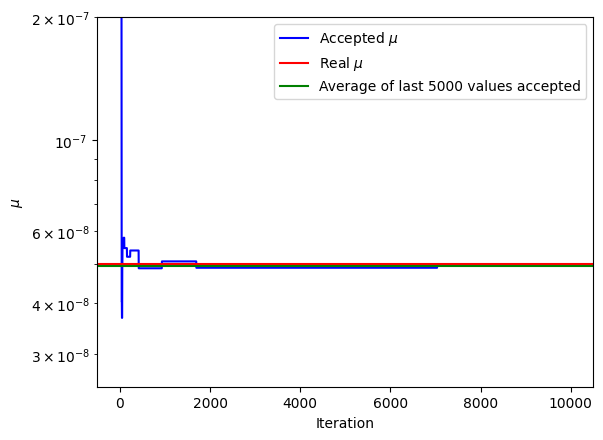

The average of last 5000 values accepted of mutation rate:  4.9249064363201786e-08
the true value of mutation rate values:  5e-08


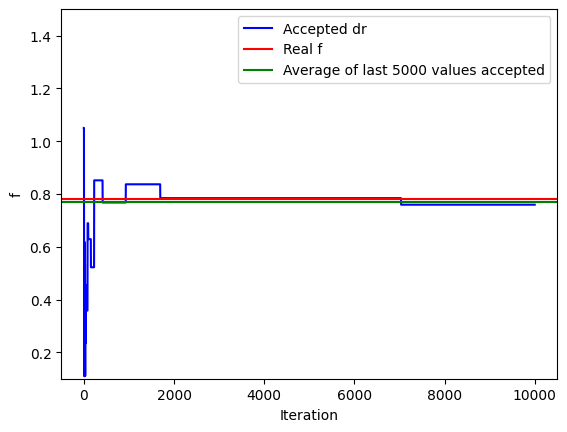

The average of last 5000 values accepted of fitness:  0.769261282801767
the true value of fitness values:  0.78


In [25]:
# Plot accepted mu values
plt.semilogy(mu_values, 'b', label='Accepted $\mu$')
plt.ylim([2.5e-8, 2e-7])
plt.xlabel('Iteration')
plt.ylabel('$\mu$')
# Plotting real value of mu
plt.axhline(y=mu, color='r', linestyle='-', label='Real $\mu$')
# Plotting average of values accepted
plt.axhline(y=np.mean(mu_values[-5000:]), color='g', linestyle='-', label='Average of last 5000 values accepted')

plt.legend()
plt.show()

print("The average of last 5000 values accepted of mutation rate: ",np.mean(mu_values[-5000:]))
print("the true value of mutation rate values: ",mu)


# Plot accepted mu values
plt.plot(f_values, 'b', label='Accepted dr')
plt.ylim([0.1, 1.5])
plt.xlabel('Iteration')
plt.ylabel('f')
# Plotting real value of mu
plt.axhline(y=f, color='r', linestyle='-', label='Real f')
# Plotting average of values accepted
plt.axhline(y=np.mean(f_values[-5000:]), color='g', linestyle='-', label='Average of last 5000 values accepted')


plt.legend()
plt.show()

print("The average of last 5000 values accepted of fitness: ",np.mean(f_values[-5000:]))
print("the true value of fitness values: ",f)

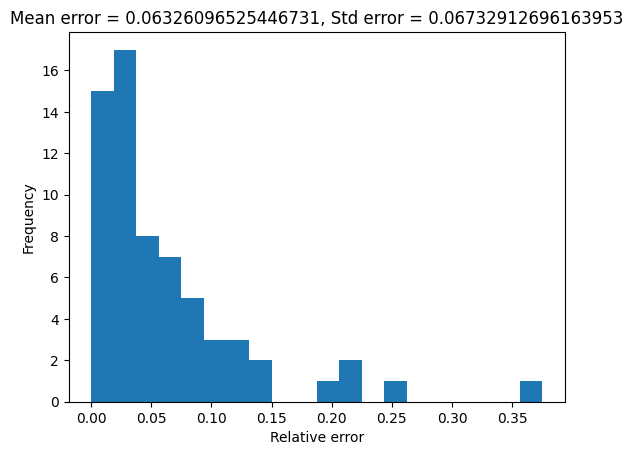

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Load true and inferred values from files
true_values = np.loadtxt("challenge3.f.true.65")
inferred_values = np.loadtxt("f_values.txt")

# Calculate relative error
relative_error = np.abs((inferred_values - true_values) / true_values)

# Calculate mean and standard deviation of the errors
mean_error = np.mean(relative_error)
std_error = np.std(relative_error)

# Plot histogram of errors
plt.hist(relative_error, bins=20)
plt.xlabel("Relative error")
plt.ylabel("Frequency")
plt.title(f"Mean error = {mean_error}, Std error = {std_error}")
plt.show()


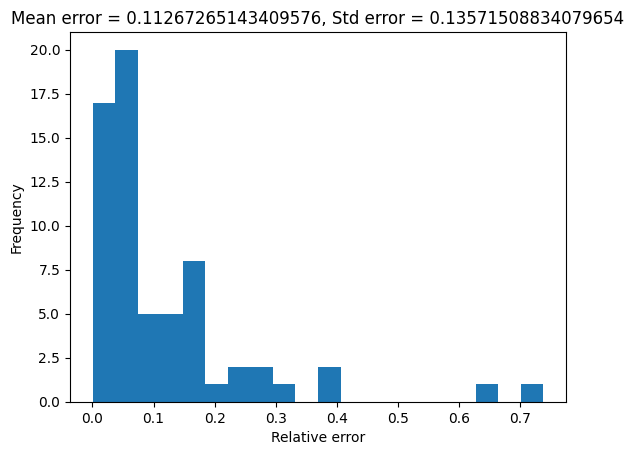

In [27]:


# Load true and inferred values from files
true_values = np.loadtxt("challenge3.mrate.true.65")
inferred_values = np.loadtxt("mu_values.txt")

# Calculate relative error
relative_error = np.abs((inferred_values - true_values) / true_values)

# Calculate mean and standard deviation of the errors
mean_error = np.mean(relative_error)
std_error = np.std(relative_error)

# Plot histogram of errors
plt.hist(relative_error, bins=20)
plt.xlabel("Relative error")
plt.ylabel("Frequency")
plt.title(f"Mean error = {mean_error}, Std error = {std_error}")
plt.show()


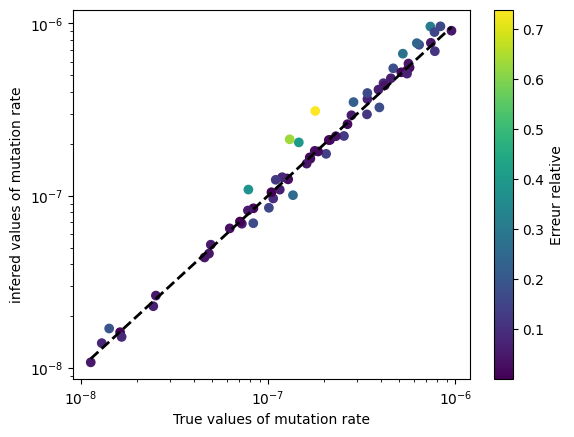

<Figure size 640x480 with 0 Axes>

In [28]:


# load data from files
true_values = np.loadtxt('challenge3.mrate.true.65')
inferred_values = np.loadtxt('mu_values.txt')

# calculate absolute difference
abs_diff = np.abs((inferred_values - true_values)/true_values)

fig, ax = plt.subplots()
scatter = ax.scatter(true_values, inferred_values, c=abs_diff, cmap='viridis')
ax.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', lw=2)  # ligne diagonale
ax.set_xlabel('True values of mutation rate')
ax.set_ylabel('infered values of mutation rate')
ax.set_xscale('log')  # échelle logarithmique sur l'axe x
ax.set_yscale('log')  # échelle logarithmique sur l'axe y
cbar = plt.colorbar(scatter)
cbar.set_label('Erreur relative')
plt.show()
plt.savefig("mutationrate")

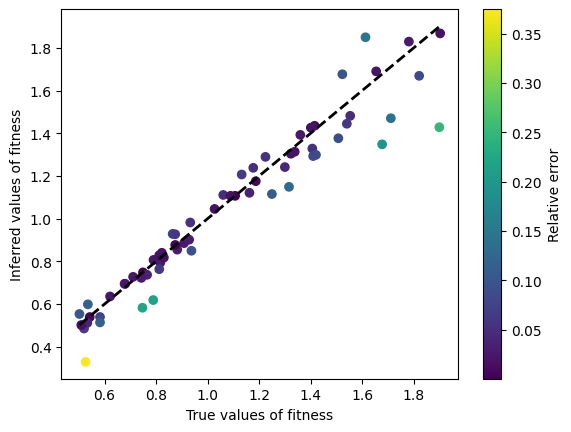

In [29]:
# load data from files
true_values = np.loadtxt('challenge3.f.true.65')
inferred_values = np.loadtxt('f_values.txt')

# calculate absolute difference
abs_diff = np.abs((inferred_values - true_values)/true_values)

fig, ax = plt.subplots()
scatter = ax.scatter(true_values, inferred_values, c=abs_diff, cmap='viridis')
ax.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', lw=2)  # diagonal line
ax.set_xlabel('True values of fitness')
ax.set_ylabel('Inferred values of fitness')
cbar = plt.colorbar(scatter)
cbar.set_label('Relative error')
plt.show()
